In [1]:
import tensorflow as tf 
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, UpSampling2D, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras.datasets import cifar100
from keras.utils.np_utils import to_categorical
import numpy as np
import cv2
import random 
from sklearn.model_selection import train_test_split
# import os

In [2]:
import matplotlib.pyplot as plt
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 100
EPOCHS = 100
INIT_DROPOUT_RATE = 0.4
MOMENTUM_RATE = 0.9
INIT_LEARNING_RATE = 0.1
L2_DECAY_RATE = 0.0005
CROP_SIZE = 32


In [4]:
(list_image, labels), (x_test, y_test) = cifar100.load_data()
x_train, x_val, y_train, y_val = train_test_split(list_image, labels, test_size=0.2, random_state=42)

169009152/169001437 [==============================] - 6s 0us/step


((32, 32, 3), array([49]))

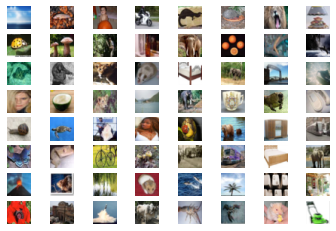

In [5]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train[random.randint(0, x_train.shape[0])], cmap='Greys')
x_train[0].shape, y_test[0]

In [6]:
datagen_train = ImageDataGenerator(rotation_range=15,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
datagen_train.fit(x_train)


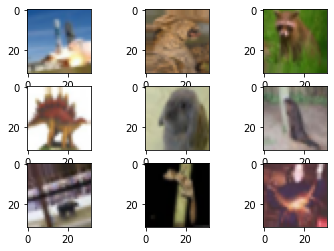

In [7]:

# see example augmentation images
for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break
# print(x_train[0])

In [8]:
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255.
x_val = x_val/255.
x_test = x_test/255.
print(x_train.shape, x_val.shape, x_test.shape)
# print(x_train[0])

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [9]:
baseModel = DenseNet201(include_top=False, weights='imagenet', input_shape=(128,128,3), classes=NUM_CLASSES)

74842112/74836368 [==============================] - 1s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.418994 to fit



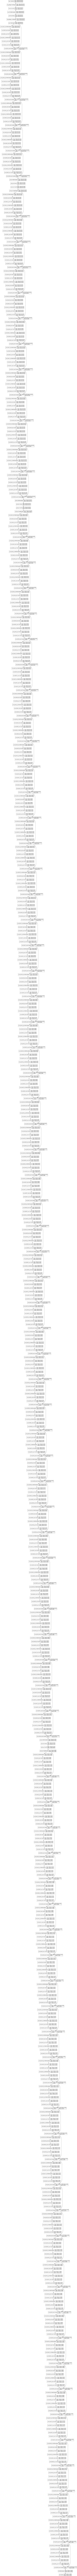

In [10]:
# ann_viz(model, title="Artificial Neural network - Model Visualization")
from keras.utils.vis_utils import plot_model
plot_model(baseModel, to_file='densenet.png', show_shapes=True, show_layer_names=True)

In [11]:
model = Sequential()
model.add(UpSampling2D((2,2)))
model.add(UpSampling2D((2,2)))
model.add(baseModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
model.build((None, 32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5

In [ ]:
model.layers[3].trainable = False

In [ ]:
train_flow = datagen_train.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
opt = RMSprop(lr=0.0001, decay=1e-6)

rlrop = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 4, 
    mode='min',                    
    factor = 0.3, 
    min_lr = 1e-8, 
    verbose = 1
)

checkpoint = ModelCheckpoint(
    "cifar_100_densenet.h5", 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    save_req=1
)

early = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=20, 
    verbose=1, 
    mode='auto'
)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
H = model.fit(train_flow,
              epochs=30,
              steps_per_epoch=len(x_train) / BATCH_SIZE,
              validation_data=(x_val, y_val),
              callbacks = [rlrop, early, checkpoint],
              validation_steps=len(x_val) / BATCH_SIZE)
model.save('cifar_100_densenet.h5')

Epoch 1/30
312/312 [==============================] - 325s 810ms/step - loss: 3.4843 - accuracy: 0.2376 - val_loss: 1.1908 - val_accuracy: 0.6697

Epoch 00001: val_accuracy improved from -inf to 0.66970, saving model to cifar_100_densenet.h5
Epoch 2/30
312/312 [==============================] - 248s 794ms/step - loss: 1.1283 - accuracy: 0.6900 - val_loss: 0.8576 - val_accuracy: 0.7531

Epoch 00002: val_accuracy improved from 0.66970 to 0.75310, saving model to cifar_100_densenet.h5
Epoch 3/30
312/312 [==============================] - 248s 793ms/step - loss: 0.7444 - accuracy: 0.7849 - val_loss: 0.7814 - val_accuracy: 0.7828

Epoch 00003: val_accuracy improved from 0.75310 to 0.78280, saving model to cifar_100_densenet.h5
Epoch 4/30
312/312 [==============================] - 248s 793ms/step - loss: 0.5504 - accuracy: 0.8399 - val_loss: 0.7722 - val_accuracy: 0.7947

Epoch 00004: val_accuracy improved from 0.78280 to 0.79470, saving model to cifar_100_densenet.h5
Epoch 5/30
312/312 [===

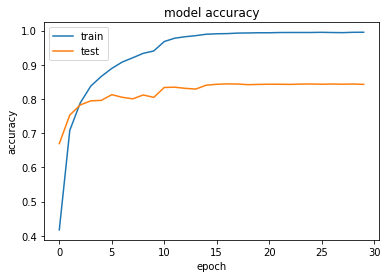

In [ ]:
plothist(H)

In [ ]:
model.save('densenet_cifar100.h5')

In [ ]:
score = model.evaluate(x_test, y_test)
print('accuracy: ',score[1])

313/313 [==============================] - 20s 58ms/step - loss: 0.8280 - accuracy: 0.8355
accuracy:  0.8355000019073486
